In [1]:
import sys
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

PACKAGEDIR = Path('/scistor/ivm/jsn295/Weave')
sys.path.append(str(PACKAGEDIR))
from Weave.inputoutput import Reader
from Weave.utils import brier_score_clim

### Small investigation of a single importance set

In [2]:
# All importances are mean_absolute_error
# Scaling the scores to 1 before group averaging? Scores in one fold are not comparable to other folds.
#testpath = '/scistor/ivm/jsn295/importance_spatcov_q09/15/-31/responsagg_separation.parquet'
testpath = '/scistor/ivm/jsn295/importance_spatcov_q08_nf5/15/-21/responsagg_separation.parquet'

In [3]:
# How should the scaling proceed when folds are not matchable over multiple separations?
dat_onesep = pd.read_parquet(testpath)

In [18]:
dat_onesep.loc[dat_onesep[('multipass','rank')] <= 20,'multipass'].loc[(0,),:].sort_values('rank')

rank     score
variable      timeagg lag separation clustid metric                 
sst_nhplus    3       -24 -21        0       spatcov   0.0  0.112541
              7       -28 -21        0       spatcov   1.0  0.114729
              5       -26 -21        0       spatcov   2.0  0.117937
              11      -32 -21        0       spatcov   3.0  0.120345
swvl13_europe 21      -42 -21        1       spatcov   4.0  0.120971
snowc_nhmin   15      -36 -21        0       spatcov   5.0  0.122127
              21      -42 -21        1       spatcov   6.0  0.125472
swvl4_europe  7       -28 -21        1       spatcov   7.0  0.125690
sst_nhplus    15      -36 -21        0       spatcov   8.0  0.125898
swvl4_europe  11      -32 -21        0       spatcov   9.0  0.126798
transp_europe 31      -52 -21        0       spatcov  10.0  0.128991
snowc_nhmin   31      -52 -21        2       spatcov  11.0  0.130877
swvl4_europe  15      -36 -21        1       spatcov  12.0  0.131774
snowc_nhmin   15      -36 -21        1       spatcov  13.0  0.133672
              11      -32 -21        1       spatcov  14.0  0.133221
              21      -42 -21        2       spatcov  15.0  0.139485
              7       -28 -21        0       spatcov  16.0  0.136427
siconc_nhmin  15      -36 -21        0       spatcov  17.0  0.136379
snowc_nhmin   11      -32 -21        0       spatcov  18.0  0.139113
z300_nhnorm   11      -32 -21        0       spatcov  19.0  0.139657

In [2]:
def scale_scores_ranks_to_importance(df, fill_multipass = False):
    """
    Ranks and scores differ over the folds. The score is MAE (default in models.permute_importance). The rank means low = important
    The score means high = important.
    Therefore I do min-max scaling
    """
    # Scores:
    def scale_score(series):
        series = (series - series.min())/(series.max() - series.min())
        if fill_multipass:
            series = series.fillna(0.0)
        return series
    df.loc[:,(slice(None),'score')] = df.loc[:,(slice(None),'score')].apply(scale_score, axis = 0)
    # Ranks: For multipass not all ranks are present (only 0 to n_important vars = 20 something) everything that is not contained gets the lowest rank
    def scale_rank(series):
        series = (series - series.max())/(series.min() - series.max())
        if fill_multipass:
            series = series.fillna(0.0)
        return series
    df.loc[:,(slice(None), 'rank')] = df.loc[:,(slice(None), 'rank')].apply(scale_rank, axis = 0)
    return df

In [20]:
# Scale to min score for scores(reference model) and max rank per rank per fold before averaging scores
# This equates variability in MAE over different evalutation folds. Option to replace the nan multipass ranks with just the shared worst possible.
# This makes multipass averaging fairer.
dat_onesep = pd.read_parquet(testpath)
dat_mean = dat_onesep.groupby('fold').apply(scale_scores_ranks_to_importance, **{'fill_multipass':False}).groupby(dat_onesep.index.names[1:]).mean() 
dat_max = dat_onesep.groupby('fold').apply(scale_scores_ranks_to_importance, **{'fill_multipass':True}).groupby(dat_onesep.index.names[1:]).max() 
dat_onesep.loc[dat_onesep['singlepass','rank'] == 7,:]

singlepass  \
                                                                rank   
fold variable      timeagg lag separation clustid metric               
0    snowc_nhmin   7       -28 -21        2       spatcov          7   
1    swvl4_europe  11      -32 -21        1       spatcov          7   
2    swvl4_europe  15      -36 -21        1       spatcov          7   
3    sst_nhplus    5       -26 -21        3       spatcov          7   
4    swvl13_europe 31      -52 -21        2       spatcov          7   

                                                                    multipass  \
                                                              score      rank   
fold variable      timeagg lag separation clustid metric                        
0    snowc_nhmin   7       -28 -21        2       spatcov  0.108973       NaN   
1    swvl4_europe  11      -32 -21        1       spatcov  0.154481      12.0   
2    swvl4_europe  15      -36 -21        1       spatcov  0.154503      10.0   
3    sst_nhplus    5       -26 -21        3       spatcov  0.109364       8.0   
4    swvl13_europe 31      -52 -21        2       spatcov  0.150307       NaN   

                                                                     
                                                              score  
fold variable      timeagg lag separation clustid metric             
0    snowc_nhmin   7       -28 -21        2       spatcov       NaN  
1    swvl4_europe  11      -32 -21        1       spatcov  0.169428  
2    swvl4_europe  15      -36 -21        1       spatcov  0.172109  
3    sst_nhplus    5       -26 -21        3       spatcov  0.128156  
4    swvl13_europe 31      -52 -21        2       spatcov       NaN

In [18]:
dat_mean

singlepass            \
                                                          rank     score   
variable     timeagg lag separation clustid metric                         
siconc_nhmin 11      -32 -21        0       spatcov   0.316071  0.407273   
                                    1       spatcov   0.635714  0.587328   
             15      -36 -21        0       spatcov   0.580357  0.627636   
                                    1       spatcov   0.446429  0.475650   
             21      -42 -21        0       spatcov   0.335714  0.425171   
...                                                        ...       ...   
z300_nhnorm  21      -42 -21        0       spatcov   0.421429  0.462104   
             3       -24 -21        0       spatcov   0.373214  0.478297   
             31      -52 -21        0       spatcov   0.225000  0.352582   
             5       -26 -21        0       spatcov   0.505357  0.495676   
             7       -28 -21        0       spatcov   0.767857  0.674626   

                                                    multipass            
                                                         rank     score  
variable     timeagg lag separation clustid metric                       
siconc_nhmin 11      -32 -21        0       spatcov  0.094737  0.075279  
                                    1       spatcov  0.000000  0.000000  
             15      -36 -21        0       spatcov  0.200000  0.197794  
                                    1       spatcov  0.010526  0.059755  
             21      -42 -21        0       spatcov  0.294737  0.213854  
...                                                       ...       ...  
z300_nhnorm  21      -42 -21        0       spatcov  0.105263  0.055684  
             3       -24 -21        0       spatcov  0.115789  0.186773  
             31      -52 -21        0       spatcov  0.042105  0.024647  
             5       -26 -21        0       spatcov  0.000000  0.000000  
             7       -28 -21        0       spatcov  0.052632  0.137642  

[113 rows x 4 columns]

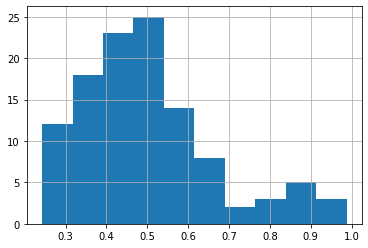

In [21]:
dat_mean['singlepass','rank'].hist()

In [ ]:
dat_onesep.loc[dat_onesep[('multipass','rank')] < 10].sort_values(by=['fold',('multipass','rank')])
#dat_onesep.loc[dat_onesep[('multipass','rank')].apply(lambda val: val in [0,19])]

The conclusion here is that the importance varies from fold to fold. And not everything is always present. For instance swvl4 

In [3]:
# Read in the clustid netcdfvariable/timescale combinations
def read_clustid_map(basepath: Path, variable: str, timeagg: int, lag: int) -> xr.DataArray:
    datapath = basepath / '.'.join([variable,str(timeagg),'corr','nc']) # e.g. clustertest_roll_spearman_varalpha/sst_nhplus.31.corr.nc 
    r = Reader(datapath = datapath, ncvarname = 'clustid')
    arr = r.read(into_shared = False, decode_lag = False)
    arr = xr.DataArray(arr, coords = r.coords, dims = r.dims, name = 'clustid')
    return arr.sel(lag = lag)

def fill_with_importance(clustid_map: xr.DataArray, imp_series : pd.Series) -> xr.DataArray:
    """
    Another function for matching the importance alpha to clustids of one field
    the imp series should contain this variable only
    Preferable this is scaled (0-1) with the other variables
    """
    clustids_series = imp_series.index.get_level_values('clustid') # Strings?
    clustids_map = np.unique(clustid_map) 
    clustids_map = clustids_map[~np.isnan(clustids_map)] # Potentially this has more clustids in it. Some might not be used by the statistical model or do not show up in the n_important vars of multipass
    assert len(clustids_series) <= len(clustids_map), 'make sure clustids are unique in your imp_series selection'
    for clustid in clustids_map:
        clustid_str = str(int(clustid))
        if clustid_str in clustids_series:
            clustid_map = clustid_map.where(clustid_map != clustid, other = imp_series.iloc[clustids_series == clustid_str][0])
        else: # Not preserving but setting to np.nan if not present in our importance series
            clustid_map = clustid_map.where(clustid_map != clustid, other = np.nan)
    return clustid_map

def plot_importance_per_sep(selection: pd.Series, basepath: Path):
    """
    plotting the importance of all variable / timeagg combinations present in that Series for a single separation 
    by displaying the geographical clusters
    """
    variables = np.unique(selection.index.get_level_values('variable')).tolist()
    timeaggs = np.unique(selection.index.get_level_values('timeagg')).astype('int')
    timeaggs.sort()
    timeaggs = timeaggs[::-1].tolist() # Reversed because of slow to fast. Actually reversed is more meaningful for separation
    
    fig, axes = plt.subplots(nrows = len(variables), ncols = len(timeaggs), squeeze=False, figsize = (3*len(timeaggs),4*len(variables)))
    
    for variable in variables:
        for timeagg in timeaggs:
            ax = axes[variables.index(variable),timeaggs.index(timeagg)]
            try:
                subset = selection.loc[(variable, str(timeagg))]
                lag = np.unique(subset.index.get_level_values('lag'))[0] # Is unique because we are working with a selection from one separation. Each timeagg has a unique lag
                clust_map = read_clustid_map(basepath = basepath, variable = variable, timeagg = timeagg, lag = int(lag))
                clust_map = fill_with_importance(clust_map,imp_series=subset)
                ax.pcolormesh(clust_map, vmin = selection.min(), vmax = selection.max())
                
            except KeyError: # This variable combination does not exist. No significant clusters are present
                pass
            ax.set_title(f'{variable} timeagg: {timeagg}')
            ax.set_axis_off()

def plot_importance_per_var(selection: pd.Series, basepath: Path):
    """
    plotting the importance of all timeagg / separation combinations present in that Series for a single variable
    by displaying the geographical clusters
    """
    variable = np.unique(selection.index.get_level_values('variable'))[0] # Should be unique, perhaps assert statement
    separations = np.unique(selection.index.get_level_values('separation')).astype('int')
    separations.sort()
    separations = separations.tolist()
    
    timeaggs = np.unique(selection.index.get_level_values('timeagg')).astype('int')
    timeaggs.sort()
    timeaggs = timeaggs.tolist()
    
    fig, axes = plt.subplots(nrows = len(timeaggs), ncols = len(separations), squeeze=False, figsize = (3*len(separations),4*len(timeaggs)))
    for separation in separations:
        for timeagg in timeaggs:
            subset = selection.loc[(slice(None),variable, str(timeagg), slice(None), str(separation))]
            ax = axes[timeaggs.index(timeagg), separations.index(separation)]
            ax.set_axis_off()
            if not subset.empty: # If empty then there are no clusters for this separation / timeagg.
                lag = np.unique(subset.index.get_level_values('lag'))[0] # Is unique because we are working with a selection from one separation. Each timeagg has a unique lag
                clust_map = read_clustid_map(basepath = basepath, variable = variable, timeagg = timeagg, lag = int(lag))
                clust_map = fill_with_importance(clust_map,imp_series=subset)
                ax.pcolormesh(clust_map,vmin = selection.min(), vmax = selection.max())
            ax.set_title(f'{timeagg},{separation}')

# single function for a plot on a basemap?

In [ ]:
selection = dat_mean.loc[(['t850_nhblock','z300_nhnorm','sst_nhplus','swvl13_europe','swvl4_europe','snowc_nhmin'],slice(None),slice(None),slice(None),slice(None),'spatcov'),('singlepass','rank')].sort_index()
plot_importance_per_sep(selection, basepath = Path('/scistor/ivm/jsn295/clusterpar3_roll_spearman_varalpha/'))

(singlepass mean rank and mean score agree). Notes on the 5-fold cv (should have less variation in the most important predictors) at a quite large separation (-21 days). Signal is more in deeper soil moisture than shallow one. Z300 does not really have the wave patterns. SST some regions. But then when it is almost one cluster (31 timeagg) less important. Multipass score agrees a tiny bit with singlepass, though with much more contrast (due to filling), but multipass rank does not agree (It highlights the short timescales). But this is interesting to look at without filling. Two conclusions:
* It does not make sense to look at multipass score (the worsening of the bs is additive)
* Highly correlated variables will both show up as important in singlepass (probably at least, when both are used in the fitting and their use is distributed). 

If important in any fold then visble here. Interesting that t850 highly important singlepass region. Also more swvl here

### Going through all the timeagg/ separation combinations.
Contains the importances of random forests with params: (max_depth = 500, n_estimators = 200, min_samples_split = 70, max_features = 0.3) using the clustered predictors 'clustertest_roll_spearman_varalpha'. They are probably overfitting.

In [4]:
basepath = Path('/scistor/ivm/jsn295/importance_spatcov_q08_nf5')

In [5]:
total = []
keys = []
for i in basepath.glob('*/*/*.parquet'):
    # You might want to scale over multiple separations, though this might lead to a problem with scores /folds that are very different. Or do it per separation (then importances are not relative to each other)
    resptimeagg, separation = i.parts[len(basepath.parts):(len(basepath.parts)+2)]
    dat_onesep = pd.read_parquet(i)
    total.append(dat_onesep)
    keys.append((resptimeagg,separation))
total = pd.concat(total, axis = 0, keys = keys) # Now separation is in there twice
total.index.names = ['respagg','separation2'] + total.index.names[2:]
total.index = total.index.droplevel('separation2')
total = total.reorder_levels([1,0] + list(range(2,8))) # To make sure that [1:] selects all except fold

In [63]:
# Question is, is the score vs fold ordering similar for all separations?
mins = total[('singlepass','score')].groupby(['fold','separation','respagg']).min() # minimum of score after permutation of a single factor should be close to the score of the original model.

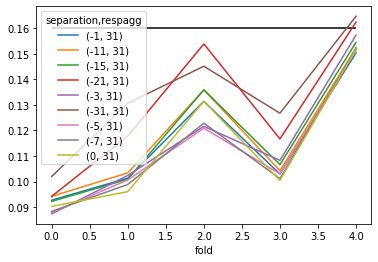

In [70]:
mins.unstack([1,2]).loc[:,(slice(None),'31')].plot()
plt.hlines(brier_score_clim(0.8), xmax=4, xmin = 0)
plt.show()

* The conclusion is that for a single separation the distribution of harder / easier periods is more or less equal. The easier validation folds have lower bs. If the ordering is equal then we can group share multiple separations under one fold and response aggregation
* Another conclusion is that performance differs over the folds. Predictability is higher in some time slices? Or model fitting fails? Last decade?

In [6]:
scale_per_fold = total.groupby(['respagg','fold']).apply(scale_scores_ranks_to_importance, **{'fill_multipass':True}).groupby(total.index.names[1:]).mean()

In [7]:
scale_per_fold_sep = total.groupby(['respagg','fold','separation']).apply(scale_scores_ranks_to_importance, **{'fill_multipass':True}).groupby(total.index.names[1:]).mean()

In [78]:
scale_per_fold_sep.loc[('7','sst_nhplus',slice(None),slice(None),slice(None),slice(None), 'spatcov'),('singlepass','rank')]

respagg  variable    timeagg  lag  separation  clustid  metric 
7        sst_nhplus  1        -1   0           0        spatcov    0.593590
                                               1        spatcov    0.476923
                                               2        spatcov    0.337179
                                               3        spatcov    0.551282
                              -12  -11         0        spatcov    0.687931
                                                                     ...   
                     7        -7   0           1        spatcov    0.466667
                              -8   -1          0        spatcov    0.672050
                                               1        spatcov    0.494410
                                               2        spatcov    0.363975
                                               3        spatcov    0.477019
Name: (singlepass, rank), Length: 277, dtype: float64

respagg  lag  clustid  metric 
7        -32  0        spatcov    0.591304
              1        spatcov    0.736646
Name: (singlepass, rank), dtype: float64
respagg  lag  clustid  metric 
7        -34  0        spatcov    0.777640
              1        spatcov    0.623602
Name: (singlepass, rank), dtype: float64
respagg  lag  clustid  metric 
7        -36  0        spatcov    0.857143
              1        spatcov    0.572671
              2        spatcov    0.776398
Name: (singlepass, rank), dtype: float64
respagg  lag  clustid  metric 
7        -38  0        spatcov    0.790062
              1        spatcov    0.608696
              2        spatcov    0.576398
Name: (singlepass, rank), dtype: float64
respagg  lag  clustid  metric 
7        -42  0        spatcov    0.664596
              1        spatcov    0.591304
              2        spatcov    0.565217
              3        spatcov    0.580124
Name: (singlepass, rank), dtype: float64
respagg  lag  clustid  metric 
7      

respagg  lag  clustid  metric 
7        -28  0        spatcov    0.303106
              1        spatcov    0.596273
              2        spatcov    0.650932
              3        spatcov    0.541615
Name: (singlepass, rank), dtype: float64
respagg  lag  clustid  metric 
7        -38  0        spatcov    0.452174
              1        spatcov    0.452174
              2        spatcov    0.659627
              3        spatcov    0.802484
              4        spatcov    0.413665
Name: (singlepass, rank), dtype: float64
respagg  lag  clustid  metric 
7        -6   0        spatcov    0.647205
              1        spatcov    0.522981
              2        spatcov    0.433540
Name: (singlepass, rank), dtype: float64
respagg  lag  clustid  metric 
7        -8   0        spatcov    0.760248
              1        spatcov    0.640994
              2        spatcov    0.354037
Name: (singlepass, rank), dtype: float64
respagg  lag  clustid  metric 
7        -10  0        spatcov    0.

respagg  lag  clustid  metric 
7        -31  0        spatcov    0.534161
              1        spatcov    0.330435
              2        spatcov    0.442236
              3        spatcov    0.390062
              4        spatcov    0.667081
              5        spatcov    0.500621
              6        spatcov    0.742857
Name: (singlepass, rank), dtype: float64


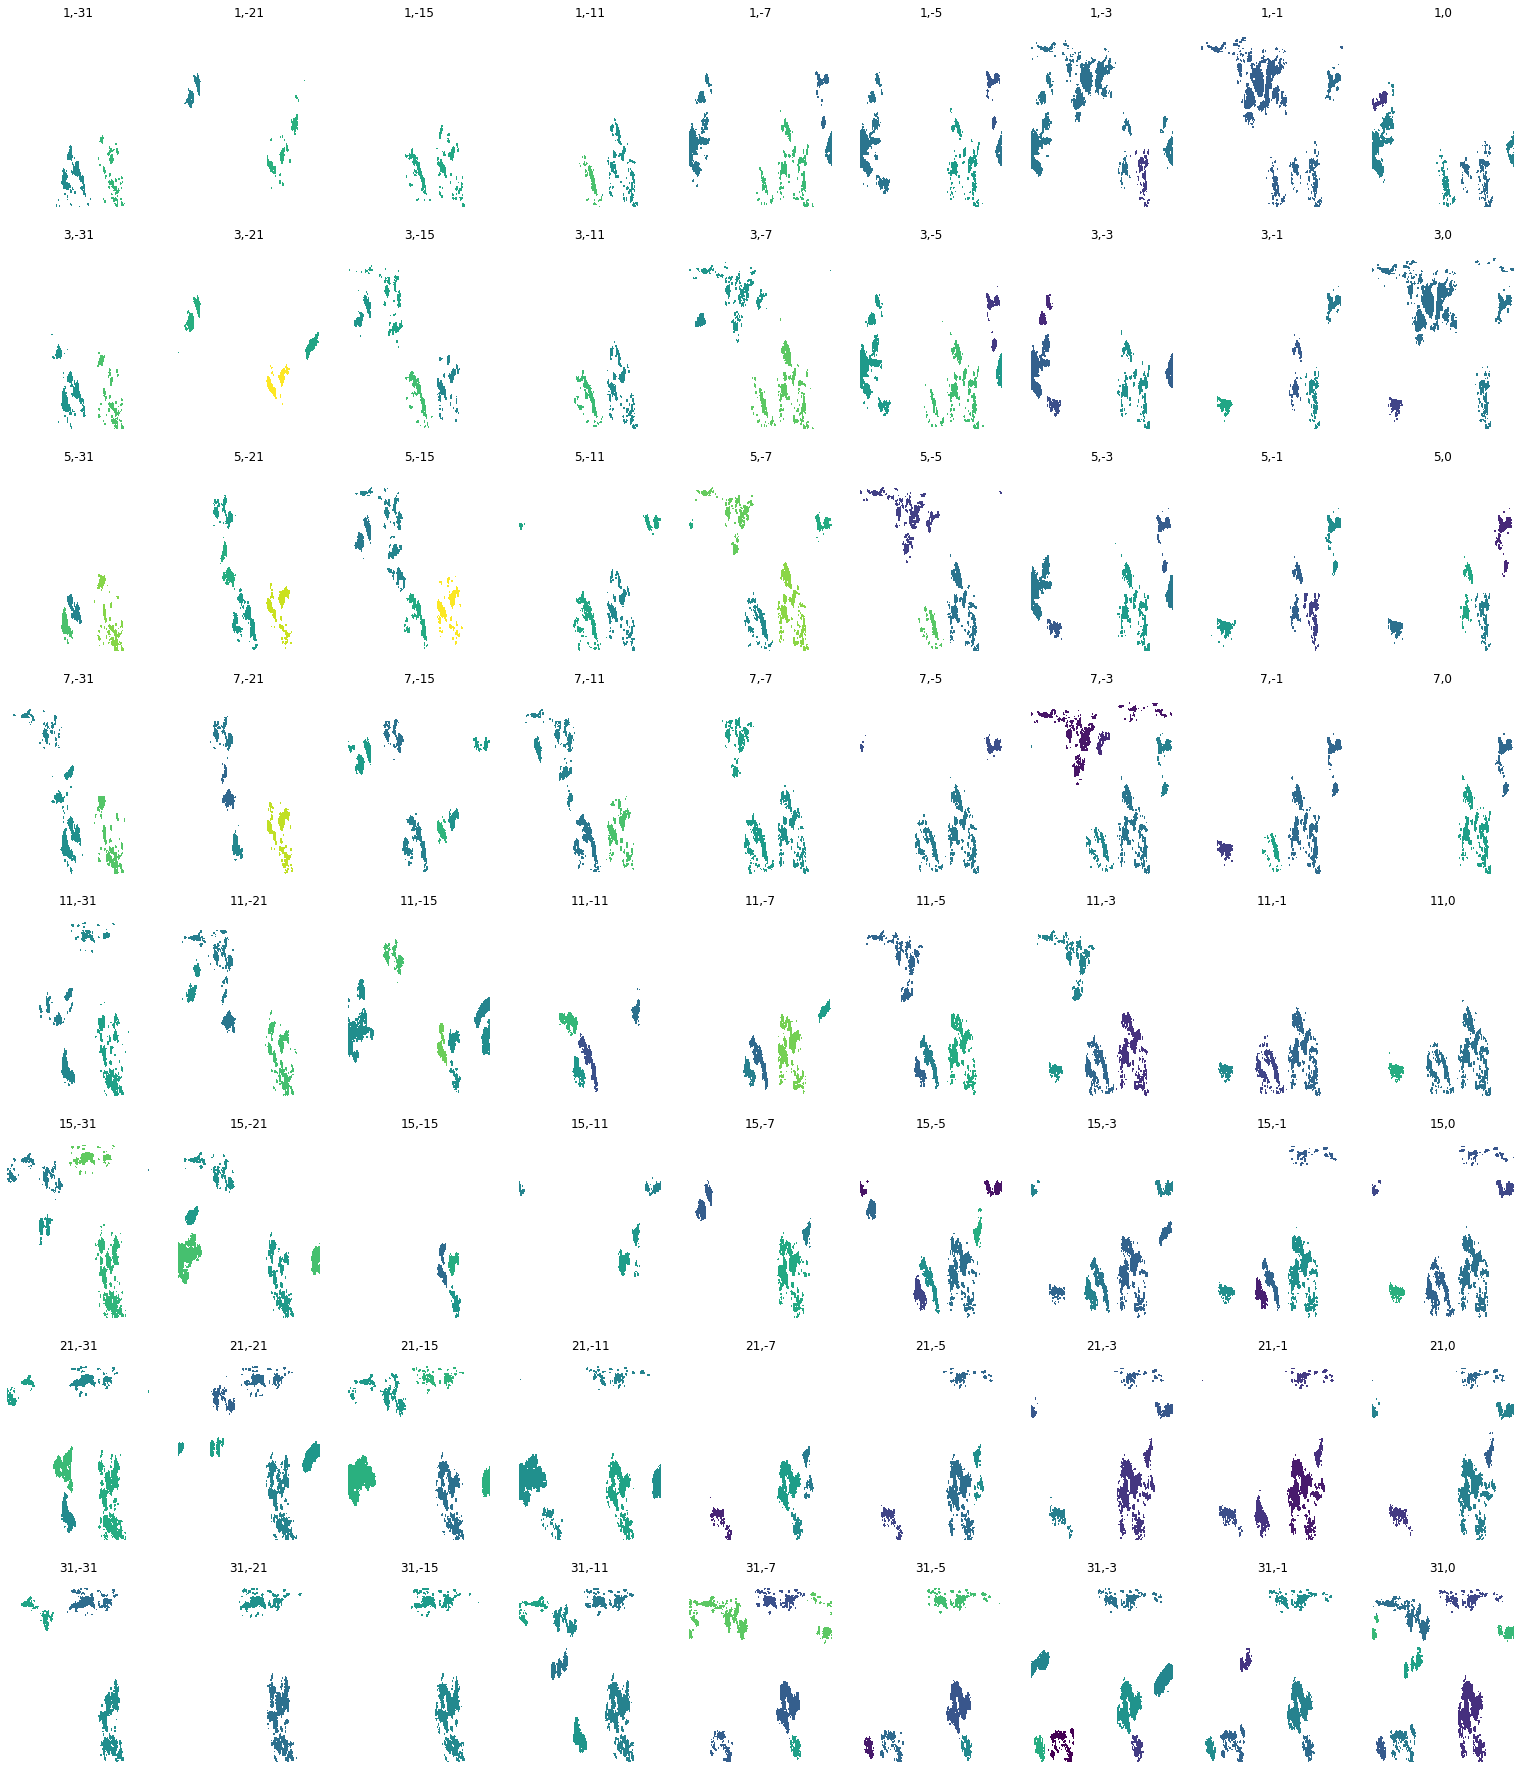

In [87]:
#plot_importance_per_var(scale_per_fold.loc[(['swvl13_europe'],slice(None),slice(None),slice(None),slice(None), 'spatcov'),('singlepass','rank')], basepath = Path('/scistor/ivm/jsn295/clustertest_roll_spearman_varalpha/'))
# Lets take on a subseasonal predictand with respagg = 11
plot_importance_per_var(scale_per_fold_sep.loc[('7','sst_nhplus',slice(None),slice(None),slice(None),slice(None), 'spatcov'),('singlepass','rank')], basepath = Path('/scistor/ivm/jsn295/clustertest_roll_spearman_varalpha/'))

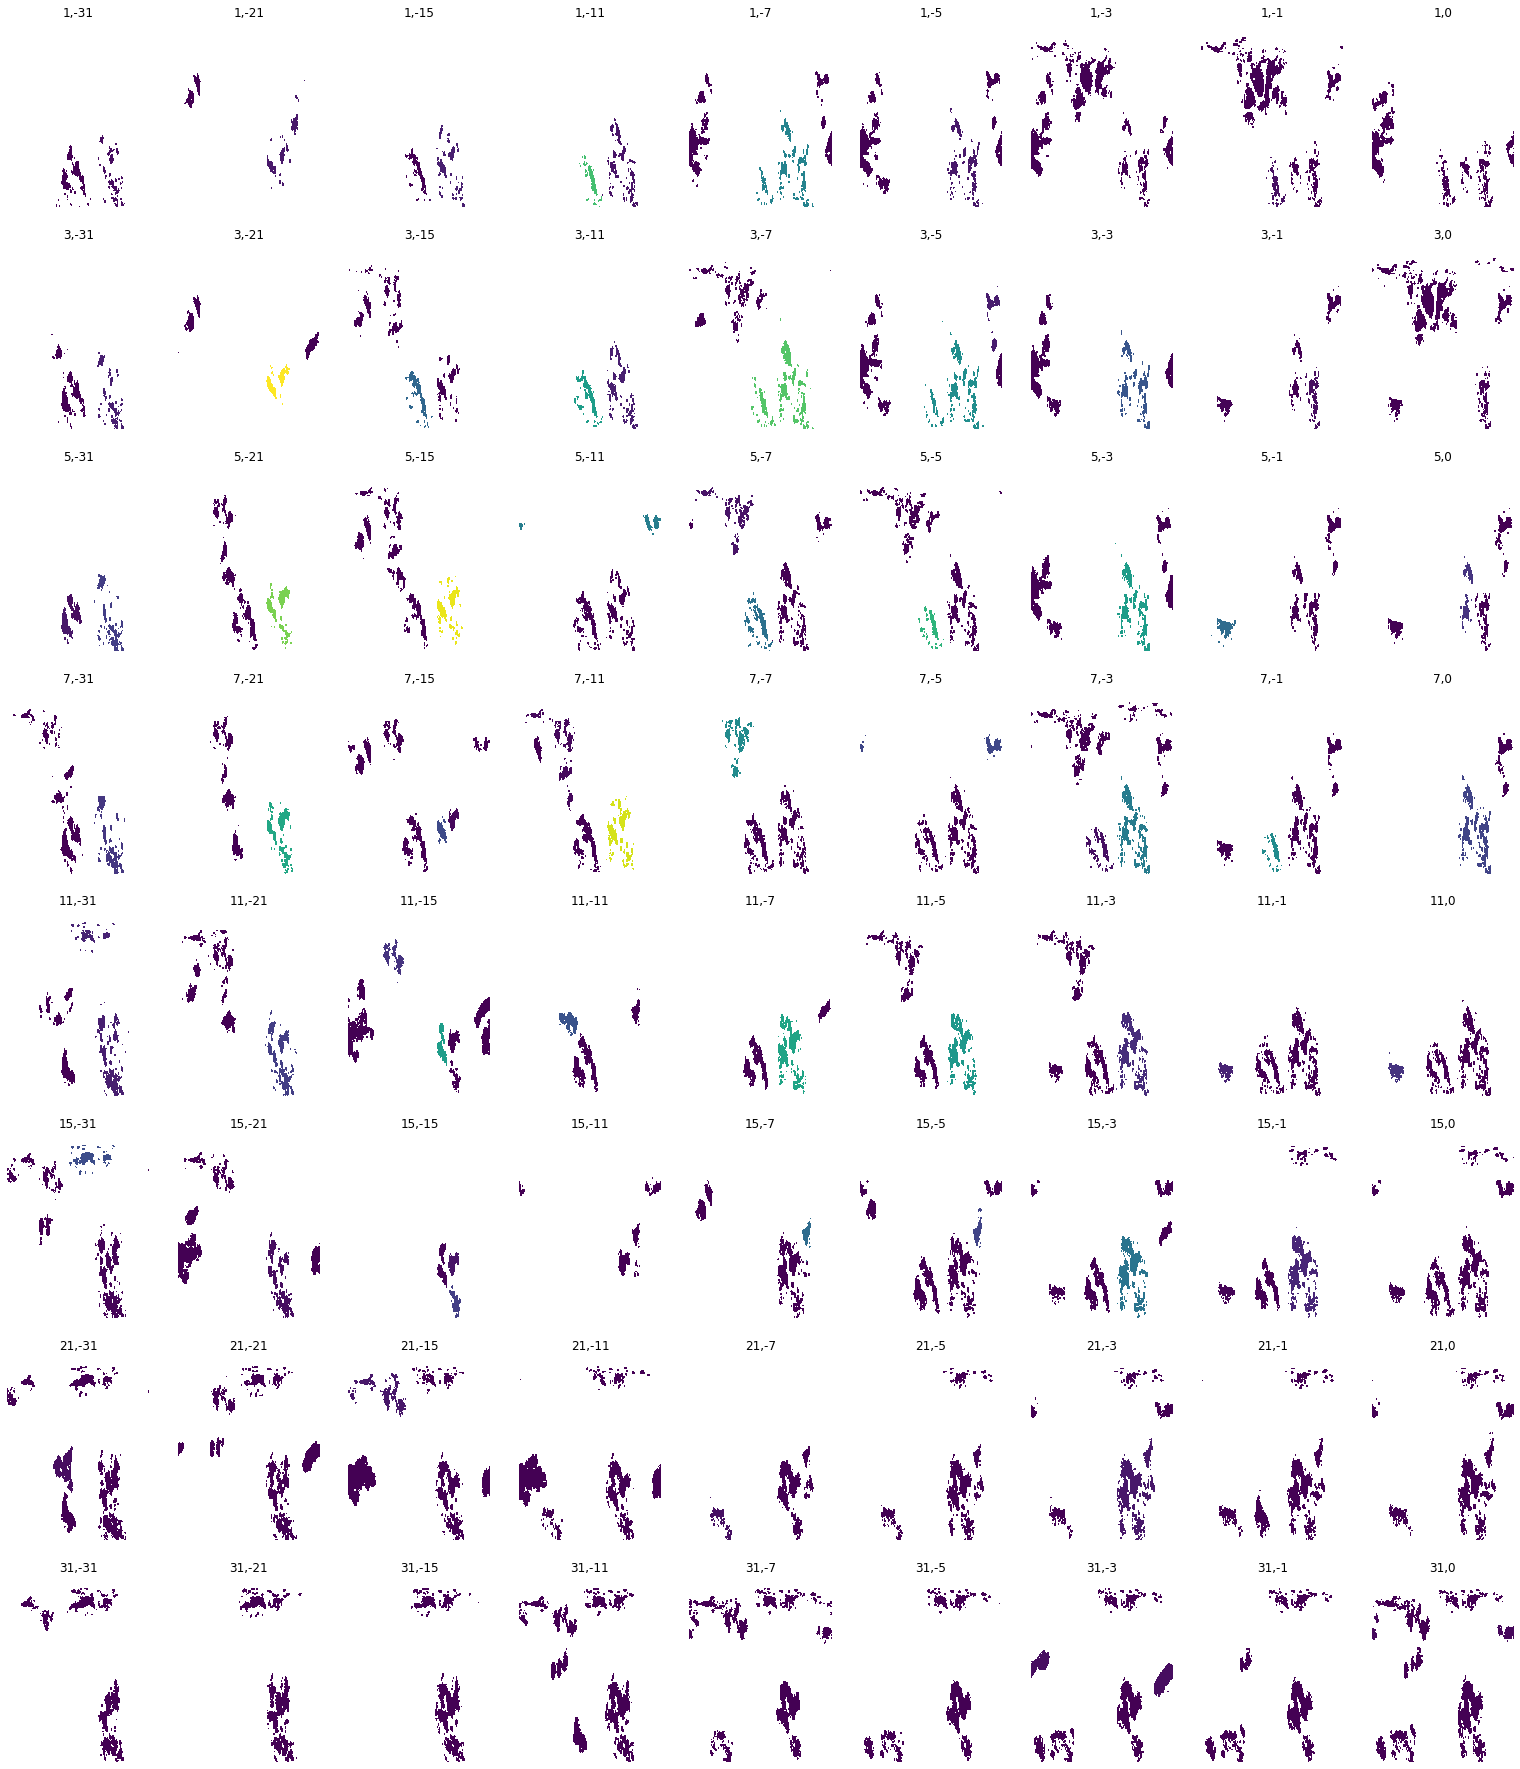

In [90]:
plot_importance_per_var(scale_per_fold_sep.loc[('7','sst_nhplus',slice(None),slice(None),slice(None),slice(None), 'spatcov'),('multipass','rank')], basepath = Path('/scistor/ivm/jsn295/clustertest_roll_spearman_varalpha/'))
# So with multipass rank the dark ones are still important but the lowest rank? otherwise nan? Check that. 

### respagg timescale visualization
Above we have visualized importance for a single response aggregation (i.e. forecasting problem) to see whether at a bigger separation other regions and timescales become important.
Now we want to see only whether the important timescales change with separation and with other forecasting settings (pooling all clusters on one pile).

In [174]:
def respagg_timescale_plot(df, variables = ['z300_nhnorm'], metric = 'spatcov', imp_measure = ('singlepass','score'), groupclustid_func = None, scaler = 0.3):
    # Let's first graph everything according to spatcov
    fullframe = df.reset_index(['respagg','timeagg']) # We need numeric x and y axes, x = respagg, y = timeagg
    fullframe['respagg'] = pd.to_numeric(fullframe['respagg'])
    fullframe['timeagg'] = pd.to_numeric(fullframe['timeagg'])
    fullframe.index.set_levels(pd.to_numeric(fullframe.index.levels[fullframe.index.names.index('separation')]), 'separation', inplace = True)
    separations = np.sort(fullframe.index.get_level_values('separation').unique()) # Need to loop over these, also need to have it in the index for selecting the frame per panel

    fig,axes = plt.subplots(ncols = len(separations), nrows = len(variables), squeeze = False, figsize = (20,3.5*len(variables)),sharey= True,sharex = True)
    for i,variable in enumerate(variables):
        for j,separation in enumerate(separations): # Will be columns
            plotframe = fullframe.loc[(variable,slice(None),separation,slice(None),metric),:]
            if not groupclustid_func is None:
                f = getattr(plotframe.groupby(['respagg','timeagg']), groupclustid_func)
                plotframe = f().reset_index(['respagg','timeagg']) # To discount the number of clust contributing to high alpha
            # Only one importance score
            rgba_colors = np.zeros((len(plotframe),4),dtype = 'float64')
            rgba_colors[:,0] = 1
            rgba_colors[:,-1] = plotframe.loc[:,imp_measure] * scaler 
            plotframe.plot.scatter(x = 'respagg', y = 'timeagg', ax = axes[i,j], color =rgba_colors)
            axes[i,j].set_ylabel('important timeagg')
            axes[i,j].set_title(f'sep: {separation}, {variable[:4]}')
    return fig, axes

def separation_timescale_plot(df, respagg = '7', variables = ['z300_nhnorm'], metric = 'spatcov', imp_measure = ('singlepass','score'), groupclustid_func = None, scaler = 0.3):
    fullframe = df.loc[(str(respagg),),:]
    fullframe = fullframe.reset_index(['timeagg','separation']) # We need numeric x and y axes, x = separation
    fullframe['separation'] = pd.to_numeric(fullframe['separation'])
    fullframe['timeagg'] = pd.to_numeric(fullframe['timeagg'])
    
    max_per_row = 3 # Maximum panels
    nrows = int(np.ceil(len(variables)/max_per_row))
    ncols = min(len(variables),max_per_row)
    fig, axes = plt.subplots(ncols = ncols, nrows = nrows, squeeze = False, figsize = (4*ncols,3.5 * nrows), sharex = True, sharey = True)
    for i,variable in enumerate(variables):
        plotframe = fullframe.loc[(variable,slice(None),slice(None),metric),:]
        if not groupclustid_func is None: # Multiple clustids can be possible in this non-geographic visualization. Doing nothing places dots on top of each other (would get the color of the latest or some aggregate alpha)
            f = getattr(plotframe.groupby(['timeagg','separation']), groupclustid_func)
            plotframe = f().reset_index(['timeagg','separation']) # To discount the number of clust contributing to high alpha
        # Only one importance score
        rgba_colors = np.zeros((len(plotframe),4),dtype = 'float64')
        rgba_colors[:,0] = 1
        rgba_colors[:,-1] = plotframe.loc[:,imp_measure] * scaler
        ax = axes[int(np.ceil((i+1)/max_per_row)) - 1,(i % max_per_row)]
        ax.scatter(x = plotframe['separation'], y = plotframe['timeagg'], s = plotframe[imp_measure] *50, color = rgba_colors)
        if (i % max_per_row) == 0:
            ax.set_ylabel('important timeagg [days]')
        if i >= (len(variables) - max_per_row):
            ax.set_xlabel('separation [days]')
        ax.set_title(f'variable {variable[:5]}')
    fig.suptitle(f'respagg {respagg}, {imp_measure}')
    return fig,axes

(<Figure size 864x756 with 9 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2aac2428d860>,
       dtype=object))

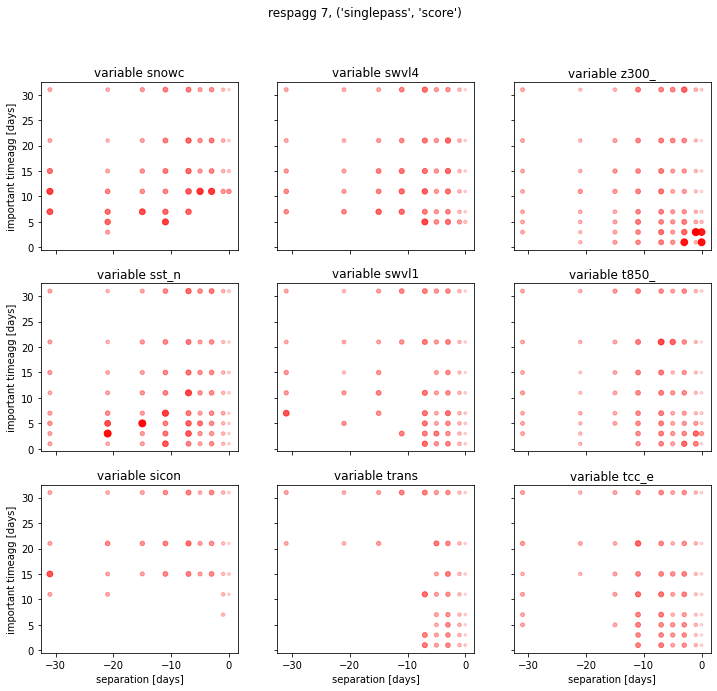

In [178]:
separation_timescale_plot(scale_per_fold_sep, respagg = '7', variables = ['snowc_nhmin','swvl4_europe','z300_nhnorm','sst_nhplus','swvl13_europe','t850_nhblock','siconc_nhmin','transp_europe','tcc_europe'], imp_measure = ('singlepass','score'), groupclustid_func = 'max', scaler = 1)

(<Figure size 864x756 with 9 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2aac257b4048>,
       dtype=object))

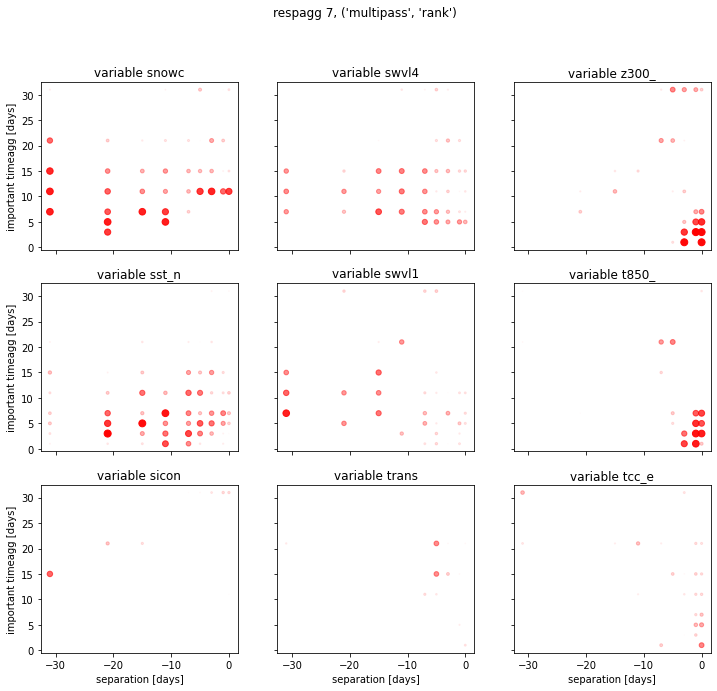

In [185]:
separation_timescale_plot(scale_per_fold_sep, respagg = '7', variables = ['snowc_nhmin','swvl4_europe','z300_nhnorm','sst_nhplus','swvl13_europe','t850_nhblock','siconc_nhmin','transp_europe','tcc_europe'], imp_measure = ('multipass','rank'), groupclustid_func = 'max', scaler = 1)

So this seems to kindof work. The ones that differentiate the best are (single_pass, score) and (multipass, rank). Also for singlepass score it matters a great deal whether you take the scale_per_fold_sep or scale_per_fold, whereas for multipass importance it does not. This I find pretty weird.
Also one interpretation that I have for when for a single separation / variable large balls are stacked on top of each other with the lowest being the most important, is that is an autocorrelated variable of which the lowest of course has the most recent information. 

Another interpretation is that the sst cutoff in the lowest corner represents the fact that it at some point follows instead of leads. Interesting that also further back, (at least for 7 day) not the longest timescale is used. 

Only at respagg 31 the longest timescale can have significant importance. And at 15. Z300 in the top?

In [166]:
def look_at_order(df,respagg = '1',importance = ('singlepass','score')):
    selection = df.loc[respagg,importance].groupby(['variable','separation']).max().unstack(-1) # Unstacking separation
    selection.columns = pd.to_numeric(selection.columns)
    return selection.sort_index(axis = 1)

In [159]:
look_at_order(scale_per_fold,importance = ('singlepass','score')) # I don't get why these values are overall larger.

separation,-31,-21,-15,-11,-7,-5,-3,-1,0
variable,,,,,,,,,
siconc_nhmin,0.899162,0.868741,0.954030,0.957520,0.936865,0.859464,0.741288,0.439558,0.009112
snowc_nhmin,0.911550,0.896140,0.956087,0.962051,0.943204,0.868679,0.743076,0.438974,0.009654
sst_nhplus,0.883883,0.885922,0.967685,0.985517,0.948480,0.868654,0.749826,0.442049,0.011163
swvl13_europe,0.887619,0.872136,0.956025,0.957791,0.938603,0.860876,0.742868,0.440056,0.012282
swvl4_europe,0.882228,0.879553,0.959384,0.963647,0.949405,0.868203,0.748808,0.441317,0.011004
t850_nhblock,0.878494,0.868986,0.954145,0.957260,0.938514,0.875118,0.761455,0.563076,0.051952
tcc_europe,0.878360,0.867173,0.955617,0.958203,0.941714,0.862636,0.742607,0.452376,0.111895
transp_europe,0.877017,0.867620,0.953823,0.953755,0.937398,0.862464,0.743145,0.460510,0.114800
z300_nhnorm,0.877291,0.870446,0.953059,0.956326,0.949845,0.893160,0.821146,0.539160,0.279578


In [169]:
look_at_order(scale_per_fold_sep, importance = ('singlepass','score')) # There are no ones in every column because scales [0-1] are averaged over the folds

separation,-31,-21,-15,-11,-7,-5,-3,-1,0
variable,,,,,,,,,
siconc_nhmin,0.568528,0.387225,0.464205,0.419709,0.487948,0.344083,0.172829,0.099267,0.035077
snowc_nhmin,0.742132,0.904955,0.542303,0.481106,0.682189,0.576239,0.196454,0.089517,0.035763
sst_nhplus,0.391467,0.731606,0.860855,0.983282,0.804732,0.513015,0.254968,0.108130,0.041790
swvl13_europe,0.377439,0.449541,0.580994,0.409359,0.525783,0.378308,0.192844,0.101100,0.044679
swvl4_europe,0.358838,0.593328,0.578350,0.556713,0.702727,0.528544,0.262798,0.106796,0.044995
t850_nhblock,0.289914,0.400166,0.540490,0.420572,0.540711,0.649926,0.384481,1.000000,0.192472
tcc_europe,0.302615,0.363091,0.544470,0.454654,0.632283,0.412819,0.185202,0.175776,0.400961
transp_europe,0.250064,0.366626,0.519028,0.346695,0.506770,0.395931,0.194566,0.254902,0.416736
z300_nhnorm,0.266740,0.420088,0.505232,0.391152,0.806510,1.000000,1.000000,0.829267,1.000000


Thinking about the scaling again I now know that the scale_per_fold is basically nonsense. A good thing is that both are scaled with respagg (different forecasting situation). But in scale_per_fold you still group bs-scores (after permutation) for the large separations with hard to predict situations. Therefore these become important and anything close the event unimportant. Unfair. We want to normalize importance per fitted model (so respagg,separation,fold).
Another noteworthy thing is that the importances [0-1] for each model are averaged over folds. You will not really encounter a hard 0 or 1 after that. Only for the small separations that seems the case, the information is really coming from only a few atmospheric predictors, and bs's diverge more. With singlepass rank you have a more ordinal scaling, making the values of a variable over separations a bit more comparable. (compare above with below)

In [168]:
look_at_order(scale_per_fold_sep, importance = ('singlepass','rank'))

separation,-31,-21,-15,-11,-7,-5,-3,-1,0
variable,,,,,,,,,
siconc_nhmin,0.694444,0.614286,0.634286,0.731034,0.618045,0.575839,0.615287,0.638509,0.600000
snowc_nhmin,0.824074,0.832143,0.777143,0.725862,0.813534,0.846980,0.710828,0.627329,0.652564
sst_nhplus,0.875926,0.948214,0.944762,0.998276,0.948872,0.759732,0.927389,0.755280,0.743590
swvl13_europe,0.779630,0.714286,0.769524,0.713793,0.678195,0.672483,0.684076,0.705590,0.762821
swvl4_europe,0.831481,0.837500,0.729524,0.739655,0.818045,0.888591,0.746497,0.816149,0.739744
t850_nhblock,0.668519,0.642857,0.638095,0.713793,0.715789,0.904698,0.984713,1.000000,0.971795
tcc_europe,0.675926,0.500000,0.746667,0.698276,0.824060,0.740940,0.636943,0.834783,0.989744
transp_europe,0.594444,0.548214,0.687619,0.441379,0.645113,0.691275,0.703185,0.970186,0.991026
z300_nhnorm,0.544444,0.712500,0.645714,0.634483,0.962406,1.000000,1.000000,0.992547,1.000000


So this is the one that in priciple would show the greatest distinction between timescales, within a variable and within a separation. I think that the absence of clear differences is a sign of poor quality fits and permutation importances.

### Skill (not importance) with resptimeagg
Select the one with the lowest absolute score, this is assigned to the variable that degrades the model the least, and therefore the most skillful prediciton.

In [110]:
best = total.loc[:,('singlepass','score')].groupby(['fold','respagg','separation']).min()
best.index.set_levels(pd.to_numeric(best.index.levels[best.index.names.index('respagg')]), 'respagg', inplace = True)
best.index.set_levels(pd.to_numeric(best.index.levels[best.index.names.index('separation')]), 'separation', inplace = True)
best = best.unstack(0)

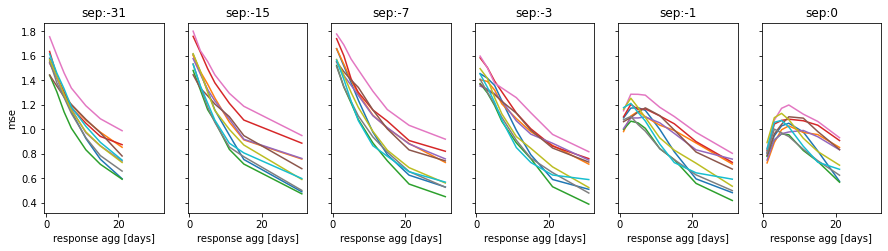

In [120]:
separations = [-31, -15, -7, -3, -1, 0]
fix, axes = plt.subplots(ncols = len(separations), sharey = True, sharex = True, figsize = (15,3.5), squeeze = False)
for i, separation in enumerate(separations):
    ax = axes[0,i]
    plotframe = best.loc[(slice(None),separation),:].sort_index()
    plotframe.index = plotframe.index.droplevel('separation')
    ax.plot(plotframe.index, plotframe)
    ax.set_title(f'sep:{separation}')
    ax.set_xlabel('response agg [days]')
    if i == 0:
        ax.set_ylabel('mse')